<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/5_xr_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install seaborn==0.9.0

In [0]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')

Create data frame of annotation info

In [0]:
features_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/feature_data_frames/annot_features_full_pain.csv'
features_path_pairing = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/feature_data_frames/annot_features_full.csv'
features_path = [features_path_pain, features_path_pairing]

In [0]:
annot_features_df = pd.DataFrame()

#Read in data frame of annotation features
for path in features_path:
  data = pd.read_csv(path)
  annot_features = pd.DataFrame(data = data)
  print(annot_features.shape)
  #check for missing values
  if annot_features.isnull().sum().sum() > 0:
    print('You have missing values in your data frame')
  else:
    print('Your data frame is complete')
  
  annot_features_df = annot_features_df.append(annot_features)

annot_features_df.replace('BBC', 'bbc', inplace=True)
print(annot_features_df.shape)
annot_features_df.head()

(1078, 13)
Your data frame is complete
(959, 13)
Your data frame is complete
(2037, 13)


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll
0,0,A2,D2,32692.5,bbc,33001.680,0.278688,35066.527850,44975.041894,2.700772,6.672909,-0.001613,33313.201458
1,1,A2,D2,97515.0,bbc,42889.350,0.209728,33325.032145,64997.459077,2.717043,6.765939,-0.002337,31658.780537
2,2,A2,D2,124942.5,bbc,32306.705,0.250006,30640.698606,49617.524980,2.513463,5.396313,-0.002205,29108.663676
3,3,A2,D2,292027.5,bbc,128251.040,0.089902,37497.496525,201737.430661,3.751878,12.999226,-0.002475,35622.621699
4,4,A2,D2,296505.0,bbc,65412.070,0.180102,35595.230449,62452.123418,3.204285,11.323622,-0.002025,33815.468927


In [0]:
print(annot_features_df['session'].value_counts())
dic ={'CPApair' : 'Schindler', 'cagepair' : 'Schindler', 'D2' : 'Land', 'D3' : 'Land', 'D4' : 'Land'} 
annot_features_df['lab'] = annot_features_df['session'].map(dic)
print(annot_features_df['lab'].value_counts())
annot_features_df['session'].replace({'D2': 'baseline', 'D3': 'snl', 'D4': 'snl+drug', 'CPApair': 'fear', 'cagepair': 'baseline'}, inplace=True)
print(annot_features_df['session'].value_counts())
annot_features_df.head()

CPApair     490
cagepair    469
D3          392
D4          347
D2          339
Name: session, dtype: int64
Land         1078
Schindler     959
Name: lab, dtype: int64
baseline    808
fear        490
snl         392
snl+drug    347
Name: session, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,lab
0,0,A2,baseline,32692.5,bbc,33001.680,0.278688,35066.527850,44975.041894,2.700772,6.672909,-0.001613,33313.201458,Land
1,1,A2,baseline,97515.0,bbc,42889.350,0.209728,33325.032145,64997.459077,2.717043,6.765939,-0.002337,31658.780537,Land
2,2,A2,baseline,124942.5,bbc,32306.705,0.250006,30640.698606,49617.524980,2.513463,5.396313,-0.002205,29108.663676,Land
3,3,A2,baseline,292027.5,bbc,128251.040,0.089902,37497.496525,201737.430661,3.751878,12.999226,-0.002475,35622.621699,Land
4,4,A2,baseline,296505.0,bbc,65412.070,0.180102,35595.230449,62452.123418,3.204285,11.323622,-0.002025,33815.468927,Land


In [0]:
annot_features_df.groupby(['lab', 'Annotation']).describe()

Unnamed: 0                                                             power_sum                                                                                                spec_cent                                                                                                   spec_kurt                                                                              spec_pur                                                                       spec_roll                                                                                                   spec_skew                                                                       spec_slope                                                                       spec_spread                                                                                                        time_stamp                                                                                    
                          count        mean         std   min     25%    50%     75%    max     count           mean            std        min           25%          50%           75%          max     count          mean           std           min           25%           50%           75%           max     count       mean        std        min        25%        50%        75%        max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max     count      mean       std       min       25%       50%       75%       max      count      mean       std       min       25%       50%       75%       max       count           mean            std           min           25%            50%            75%            max      count           mean            std      min         25%        50%         75%       max
lab       Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Land      bbc             178.0   88.500000   51.528309   0.0   44.25   88.5  132.75  177.0     178.0   50731.051506   41822.825325  15415.630   29378.28900   34589.3515   55584.91750    350587.62     178.0  33049.863884   5112.292861  19510.444892  29884.997728  32954.555754  36011.021083  49536.698653     178.0  14.687762   9.491488  -0.118863   7.220186  12.647498  19.512482  42.441590    178.0  0.239406  0.076033  0.055395  0.190478  0.250679  0.288418  0.452791     178.0  31397.370690   4856.678218  18534.922647  28390.747842  31306.827966  34210.470029  47059.863720     178.0  3.554693  1.131336  0.169895  2.722355  3.481161  4.305429  6.360582      178.0 -0.001875  0.000578 -0.002788 -0.002163 -0.001973 -0.001721  0.001387       178.0   73138.833768   48864.970569   6206.632577  40404.321256   64707.748995   93492.256546  348444.606763      178.0  131690.477528   91159.682643   1327.5   45810.000  119362.50  200953.125  297652.5
          rand_noise      900.0  449.500000  259.951919   0.0  224.75  449.5  674.25  899.0     900.0   33787.308716  130512.857831  13971.504   16483.41675   18665.3250   24040.57950   3630241.00     900.0  39839.066306 

In [0]:
def annotations_to_classes_df(dataframe, annot_dic):
  """takes in dataframe of computed slice features and a dictonary containing the annotation classes as keys and 
  annotation names as values (you will need to create this) and generates a new dataframe specific to the dic"""

  i = 0
  annot_features_classes = pd.DataFrame()
  while i < len(annot_dic):
    annot_df = dataframe[dataframe['Annotation'] == annot_dic[i]]
    annot_df['class'] = i
    annot_features_classes = pd.concat([annot_features_classes, annot_df], axis = 0)
    i = i + 1
    
  return annot_features_classes
                         

In [0]:
#create dictionary containing annotation types and corresponding class variable that you wish to use for model generation
annot_dic = {0: 'rand_noise', 1: 'bbc'}

annot_features_classes = annotations_to_classes_df(annot_features_df, annot_dic)
print(annot_features_classes.shape)
print(annot_features_classes['Annotation'].value_counts())
annot_features_classes.head()

(1923, 15)
rand_noise    1700
bbc            223
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,lab,class
178,0,A2,baseline,287370.0,rand_noise,32637.334,0.467122,52193.077117,15364.418940,1.233759,2.545437,0.002049,49583.423261,Land,0
179,1,A2,baseline,285930.0,rand_noise,3630241.000,0.382402,37256.982462,8912.674088,2.900484,14.702144,0.000107,35394.133339,Land,0
180,2,A2,baseline,171427.5,rand_noise,26265.760,0.418324,35505.780311,13554.983285,3.913268,21.813667,0.000265,33730.491296,Land,0
181,3,A2,baseline,258075.0,rand_noise,53435.670,0.273909,25268.071169,7323.371567,2.387470,6.057186,-0.000652,24004.667610,Land,0
182,4,A2,baseline,51750.0,rand_noise,20395.050,0.404291,40755.530899,6211.107865,0.404921,0.260300,0.000644,38717.754354,Land,0


In [0]:
orig_maj = annot_features_classes[annot_features_classes['Annotation'] == 'rand_noise']
orig_min = annot_features_classes[annot_features_classes['Annotation'] != 'rand_noise']

orig_min_upsamples = resample(orig_min, replace=True, n_samples = len(orig_maj), random_state = 123)

orig_upsamples = pd.concat([orig_min_upsamples, orig_maj])

print(orig_upsamples.Annotation.value_counts())

orig_upsamples.head()

rand_noise    1700
bbc           1700
Name: Annotation, dtype: int64


,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,lab,class
109,109,A10,snl,296842.5,bbc,147112.030,0.079486,27146.363810,79606.848947,4.478367,22.926085,-0.002582,25789.045620,Land,1
126,126,A12,snl,202297.5,bbc,30843.863,0.251352,29445.532200,61224.268449,3.378815,11.089863,-0.002114,27973.255590,Land,1
66,66,A4,snl,283522.5,bbc,30438.070,0.265006,39484.209813,158908.430561,3.728488,13.879313,-0.002134,37509.999322,Land,1
155,155,559,fear,136215.0,bbc,166691.470,0.087057,32393.071102,102156.254267,3.421312,11.912689,-0.002698,30773.417547,Schindler,1
98,98,A10,snl,45652.5,bbc,56781.766,0.177977,27497.284928,36245.250928,2.957472,10.321309,-0.002252,26122.420682,Land,1


In [0]:
annot_features_up = orig_upsamples[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]

In [0]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features_up)

[0.42140810486893754, 0.34179177809463157, 0.34356601353379607, 0.34272194505460046, 0.3458415466852516, 0.3636787050573286, 0.35518738592484445, 0.35776860500382107, 0.3289771812735828, 0.3210467467957598, 0.321505970540072, 0.32262635080326524, 0.33648527294009106, 0.33877323382419516, 0.3399703809663957, 0.3352151810743124, 0.3374625335287231, 0.3444316071864105, 0.34079843180098857, 0.31180399218165067, 0.31566294541526396, 0.32953087899930306, 0.31764293988703163, 0.3224397279373292, 0.3286347725104423, 0.32195185104538676, 0.3163000765653304, 0.32663767807458055]


Text(0, 0.5, 'Silhouette Coefficient')

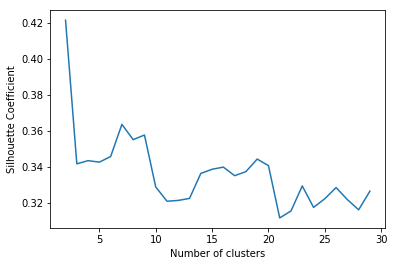

In [0]:
k_range = range(2,30)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=19)
    km_ss.fit(features_scaled)
    scores.append(silhouette_score(features_scaled, km_ss.labels_))

print(scores)

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [0]:
km2 = KMeans(n_clusters=2,random_state=19)
km2.fit(features_scaled)
score = silhouette_score(features_scaled, km2.labels_)
orig_upsamples['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
print(score)

0.42140810486893754


In [0]:
orig_upsamples.groupby(['Annotation', 'session'])['kmeans_2_scaled'].value_counts()

Annotation  session   kmeans_2_scaled
bbc         baseline  cluster_0          533
                      cluster_1           15
            fear      cluster_0           90
            snl       cluster_0          666
                      cluster_1           36
            snl+drug  cluster_0          344
                      cluster_1           16
rand_noise  baseline  cluster_1          563
                      cluster_0          137
            fear      cluster_0          204
                      cluster_1          196
            snl       cluster_1          248
                      cluster_0           52
            snl+drug  cluster_1          253
                      cluster_0           47
Name: kmeans_2_scaled, dtype: int64

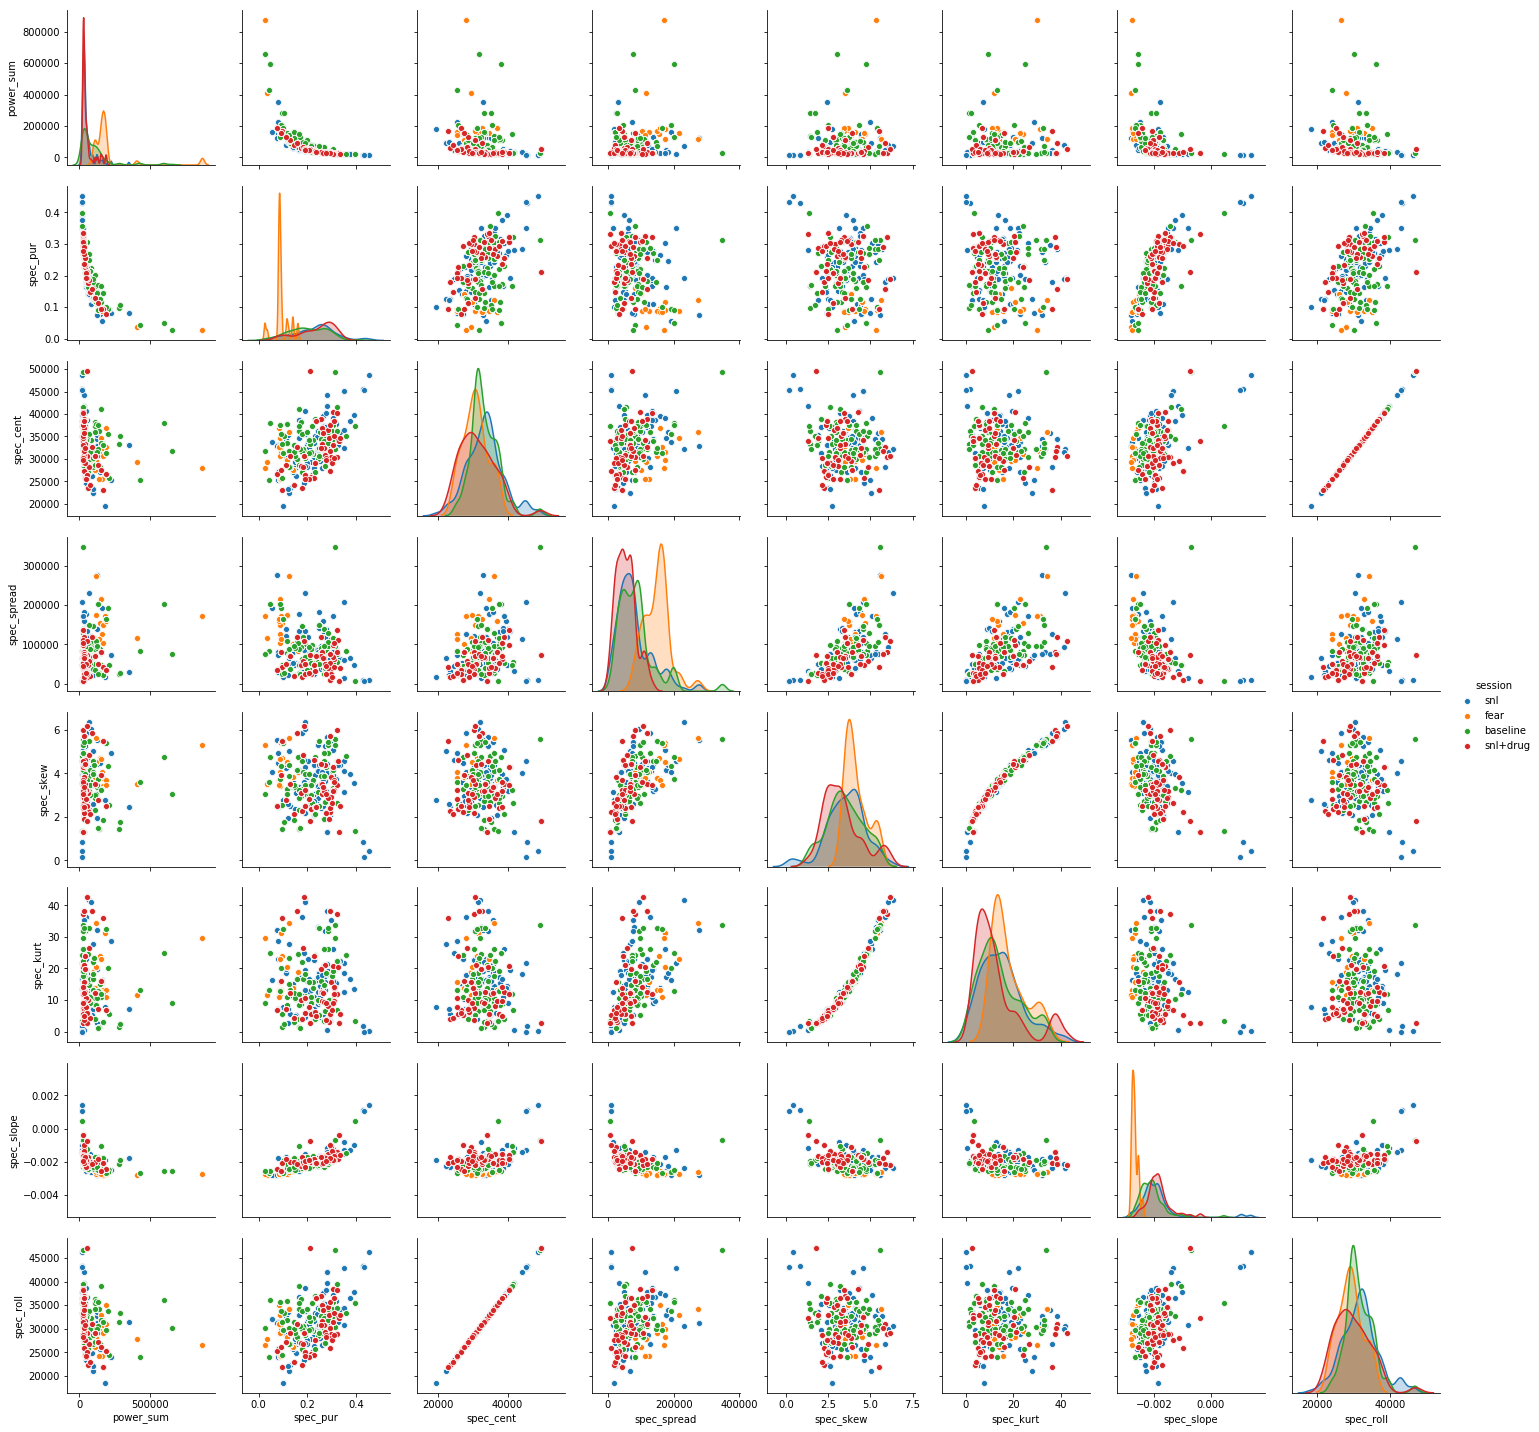

In [0]:
sns.pairplot(orig_upsamples[orig_upsamples['Annotation'] == 'bbc'], vars=['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll'], hue="session")

In [0]:
orig_min_upsamples.columns.values

array(['Unnamed: 0', 'animal_number', 'session', 'time_stamp',
       'Annotation', 'power_sum', 'spec_pur', 'spec_cent', 'spec_spread',
       'spec_skew', 'spec_kurt', 'spec_slope', 'spec_roll', 'class'],
      dtype=object)

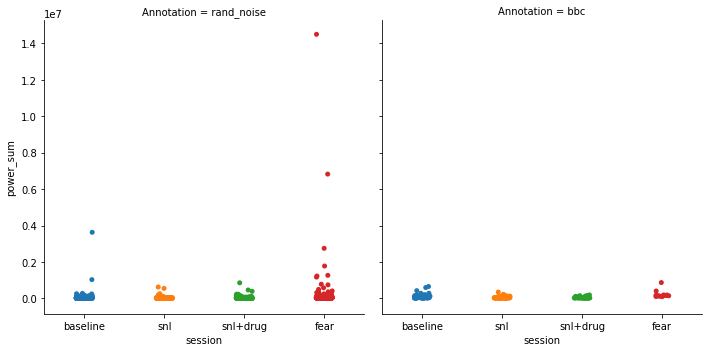

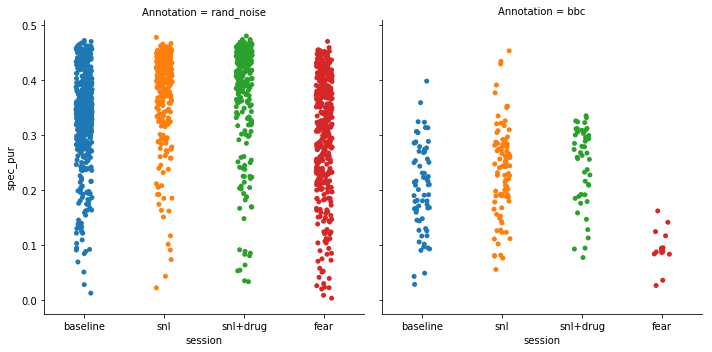

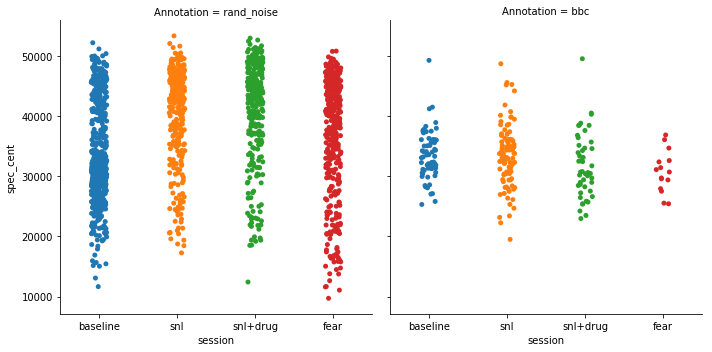

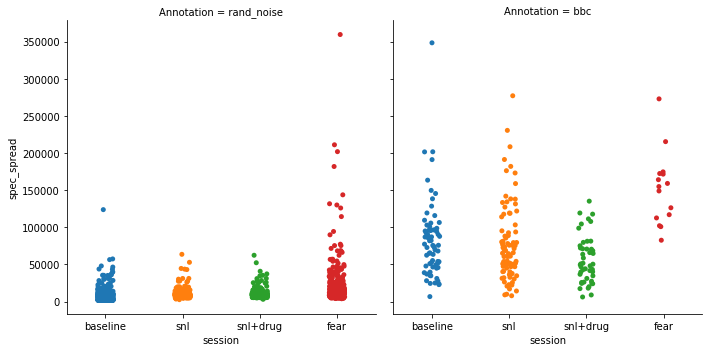

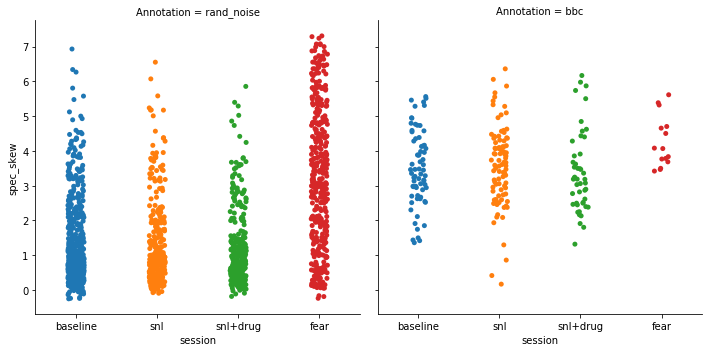

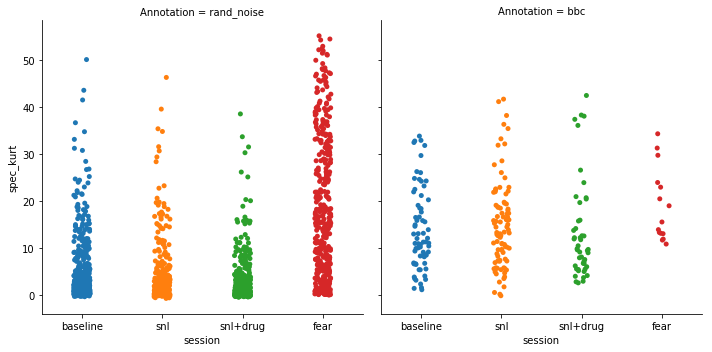

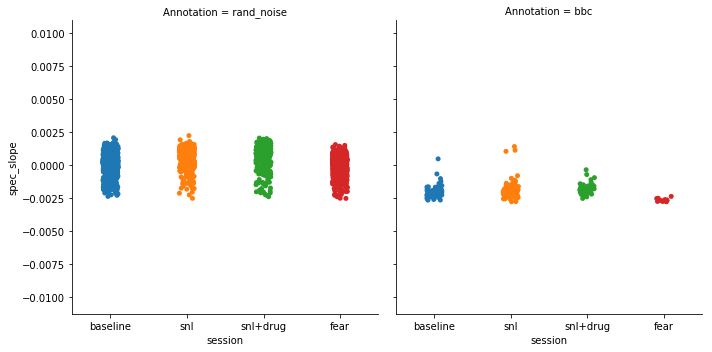

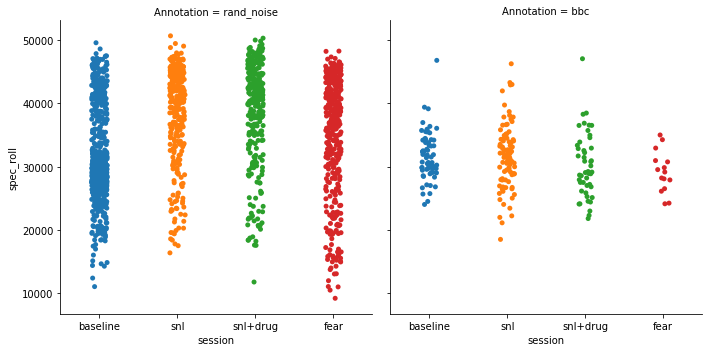

In [0]:

feature_cols = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread',
       'spec_skew', 'spec_kurt', 'spec_slope', 'spec_roll']
for feature in feature_cols:
  sns.catplot(x="session", y=feature, col='Annotation', data=annot_features_classes)

In [0]:
%%time
# This function can take a long to run
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(features_scaled)

CPU times: user 24.3 s, sys: 171 ms, total: 24.5 s
Wall time: 24.5 s


In [0]:
orig_upsamples.head()

,Unnamed: 0,animal_number,session,time_stamp,Annotation,power_sum,spec_pur,spec_cent,spec_spread,spec_skew,spec_kurt,spec_slope,spec_roll,class,kmeans_2_scaled
109,109,A10,D3,296842.5,bbc,147112.030,0.079486,27146.363810,79606.848947,4.478367,22.926085,-0.002582,25789.045620,1,cluster_0
126,126,A12,D3,202297.5,bbc,30843.863,0.251352,29445.532200,61224.268449,3.378815,11.089863,-0.002114,27973.255590,1,cluster_0
66,66,A4,D3,283522.5,bbc,30438.070,0.265006,39484.209813,158908.430561,3.728488,13.879313,-0.002134,37509.999322,1,cluster_0
155,155,559,CPApair,136215.0,bbc,166691.470,0.087057,32393.071102,102156.254267,3.421312,11.912689,-0.002698,30773.417547,1,cluster_0
98,98,A10,D3,45652.5,bbc,56781.766,0.177977,27497.284928,36245.250928,2.957472,10.321309,-0.002252,26122.420682,1,cluster_0


In [0]:
print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = orig_upsamples['Unnamed: 0'])
tsne_df['label'] = orig_upsamples['class'].values
tsne_df['session'] = orig_upsamples['session'].values
tsne_df['Annotation'] = orig_upsamples['Annotation'].values
tsne_df.head()

(3400, 2)


,tsne_0,tsne_1,label,session,Annotation
Unnamed: 0,,,,,
109,-4.749256,-36.467369,1,D3,bbc
126,32.817429,8.716768,1,D3,bbc
66,75.079376,-30.584841,1,D3,bbc
155,30.415066,-44.499767,1,CPApair,bbc
98,-53.633686,-48.290592,1,D3,bbc


Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

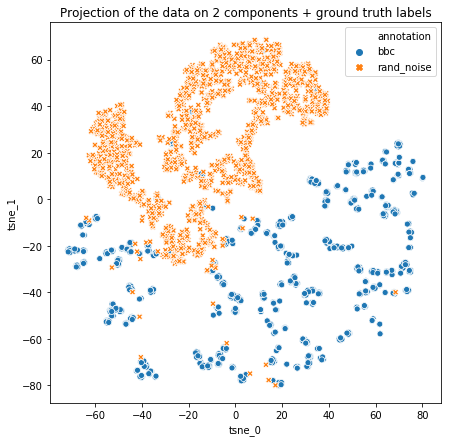

In [0]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'Annotation', data = tsne_df, style = 'annotation')
plt.title("Projection of the data on 2 components + ground truth labels")

<Figure size 504x504 with 0 Axes>

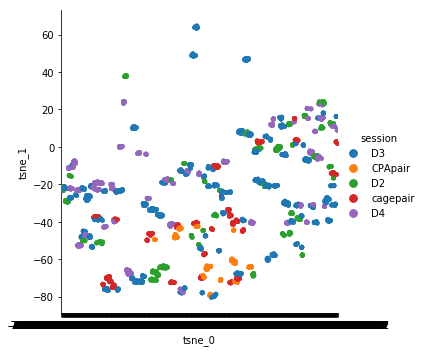

In [0]:
plt.figure(figsize=(7,7))
#sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'session', data = tsne_df[tsne_df['Annotation'] == 'bbc'])
sns.catplot(x="tsne_0", y='tsne_1', hue='session', data=tsne_df[tsne_df['Annotation'] == 'bbc'])
#plt.title("Projection of the data on 2 components + ground truth labels")

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8, whiten=True)
pca_features = pca.fit_transform(features_scaled)

In [0]:
print(features_scaled.shape)
print(pca_features.shape)
print(pca.components_.shape)
pca_features[0]

(1600, 8)
(1600, 8)
(8, 8)


array([ 0.88447688,  0.4640141 ,  1.13350678, -1.88002793, -0.53896633,
       -0.44420148, -0.29245005, -2.80356472])

In [0]:
orig_upsamples.columns.values

array(['Unnamed: 0', 'animal_number', 'session', 'time_stamp',
       'Annotation', 'power_sum', 'spec_pur', 'spec_cent', 'spec_spread',
       'spec_skew', 'spec_kurt', 'spec_slope', 'spec_roll', 'Label',
       'kmeans_7_scaled'], dtype=object)

Text(0, 0.5, 'Component')

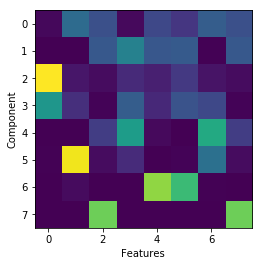

In [0]:
plt.imshow(pca.components_**2)
plt.xlabel('Features')
plt.ylabel('Component')

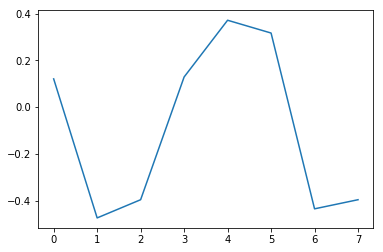

In [0]:
plt.plot(pca.components_[0, :])

In [0]:
pca_df = pd.DataFrame(data = pca_features, columns = ['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7'], index = orig_upsamples['Unnamed: 0'])
pca_df['label'] = orig_upsamples['Label'].values
pca_df['annotation'] = orig_upsamples['Annotation'].values
print(pca_df.shape)
print(pca_df.annotation.value_counts())
pca_df.head()

(1600, 10)
rand_noise    800
low slug      306
bbc           245
high slug     126
low multi     106
high multi     17
Name: annotation, dtype: int64


,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,label,annotation
Unnamed: 0,,,,,,,,,,
109,0.884477,0.464014,1.133507,-1.880028,-0.538966,-0.444201,-0.292450,-2.803565,1,bbc
126,-0.277669,0.587418,0.721192,-0.714002,-1.726931,2.317788,-0.036832,10.704487,1,bbc
66,-0.738435,-0.104058,-0.476430,0.534847,-0.139707,-1.821741,-1.224291,-3.245673,1,low slug
98,0.089574,0.379195,0.977892,-1.528763,-1.723859,-0.064839,-0.067235,-0.984930,1,bbc
17,2.183321,-0.199672,-1.001653,1.157412,1.087692,0.769774,1.584564,-0.397223,1,low slug


Text(0.5, 1.0, 'Singular values')

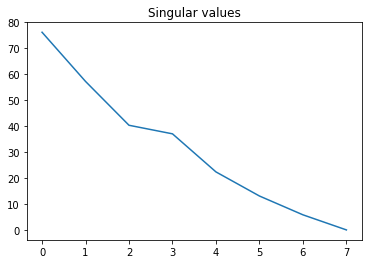

In [0]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

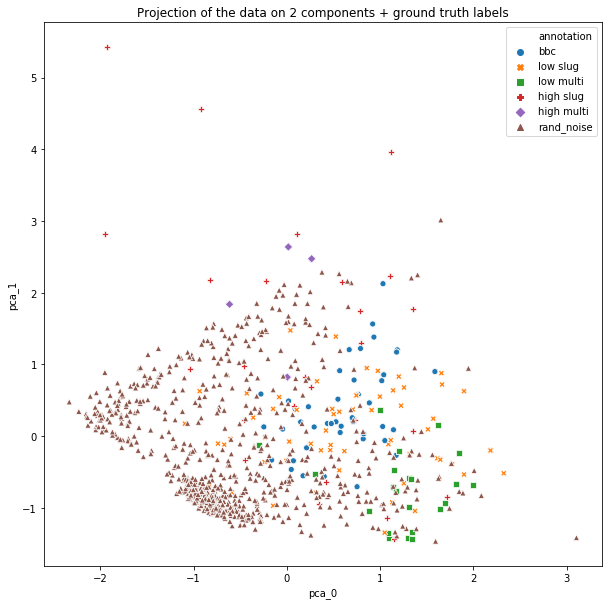

In [0]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'pca_0', y = 'pca_1', hue = 'annotation', data = pca_df, style = 'annotation')
plt.title("Projection of the data on 2 components + ground truth labels")

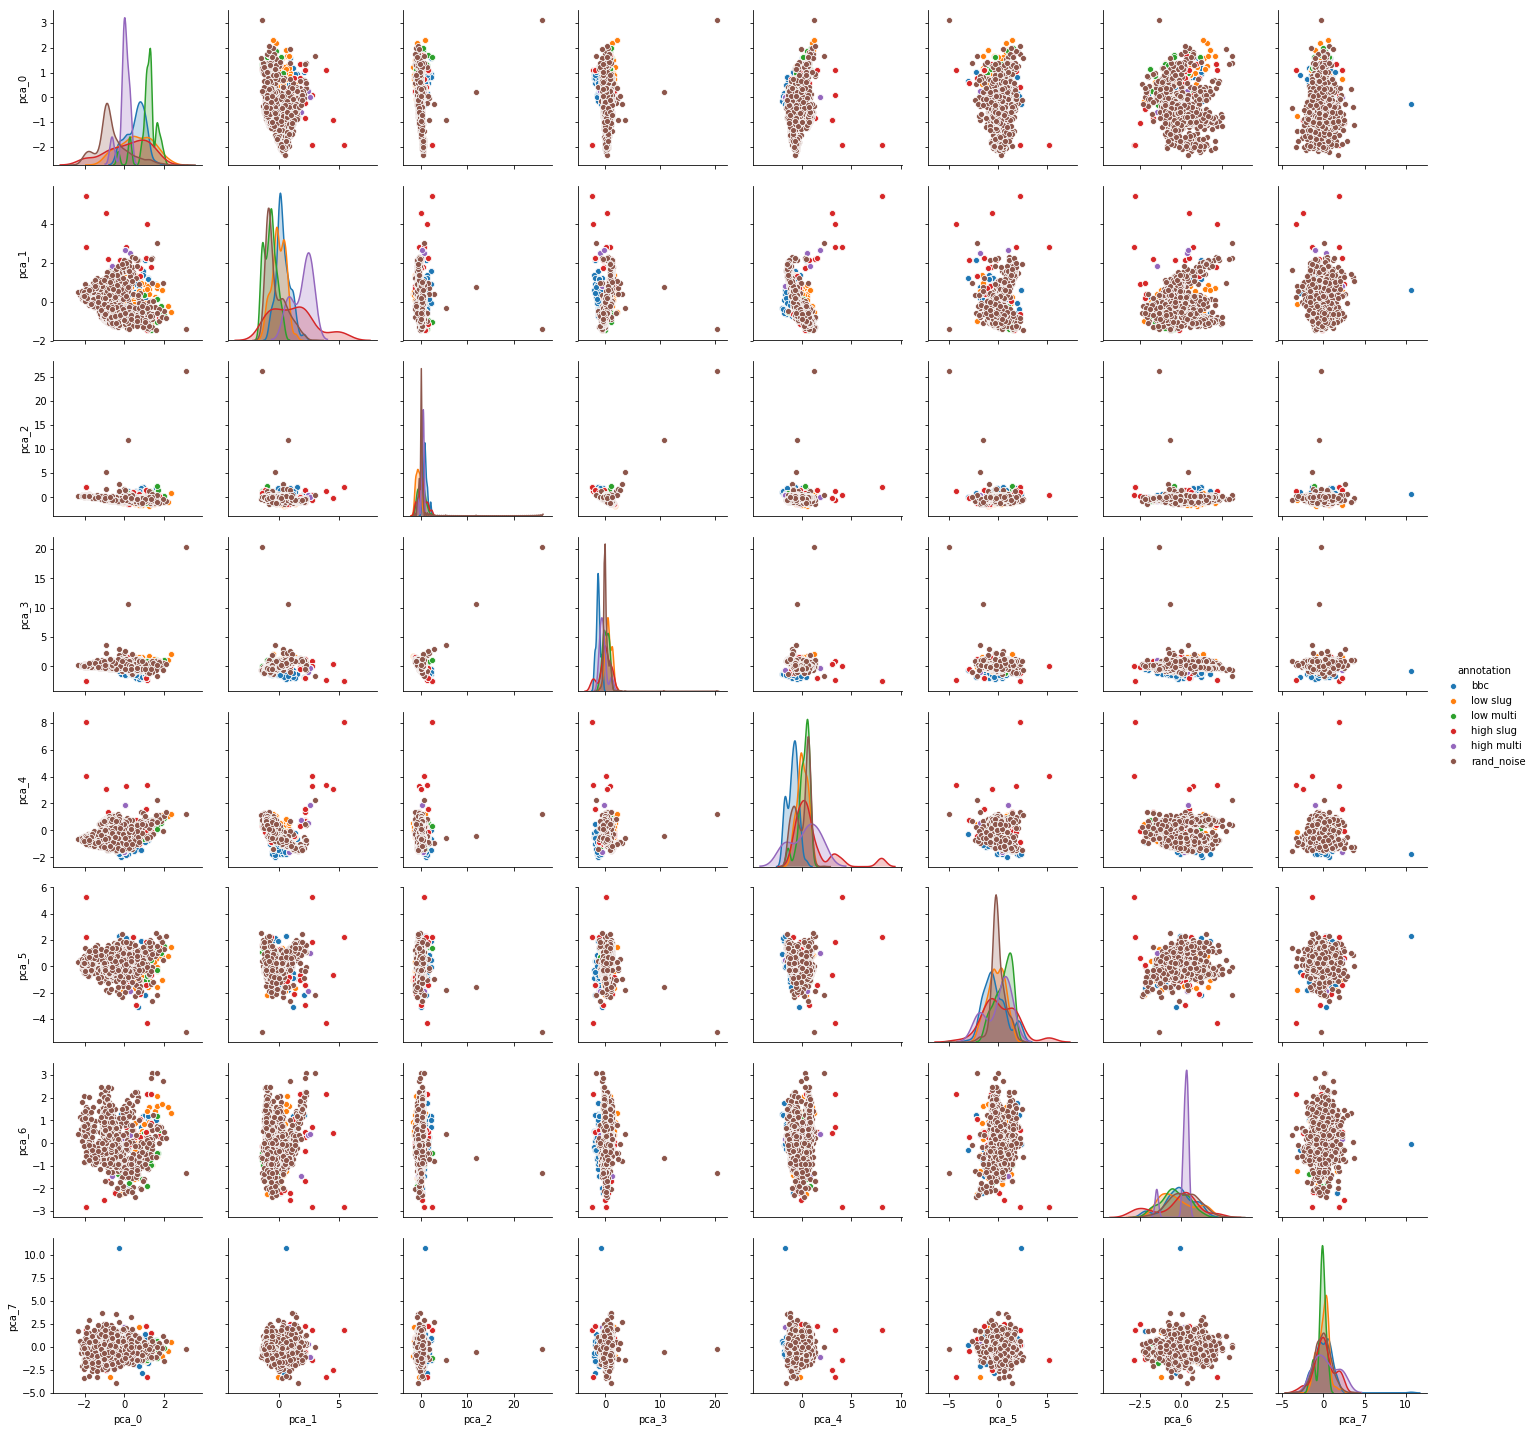

In [0]:
sns.pairplot(pca_df, vars=['pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6',
       'pca_7'], hue="annotation")

In [0]:
specs = []
for index, row in orig_upsamples.iterrows():
    data = xr.open_dataset('C:/Users/Schindler/Documents/ProgrammingFun/USV_python/Datasets/' + str(row['animal_number']) + '_xr_Dataset.nc')
    
    xr_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp']).values
    
    times = data['times'].values
    freqs = data['freq'].values
    
    specs.append(xr_slice)
    
X = np.stack(specs)
y = annot_labels_up.values
print(X.shape)
print(y.shape)

(1600, 257, 55)
(1600,)


In [0]:
# The code below visualizes the data projected in 2D together with the original spectrograms

from matplotlib import offsetbox
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
# Scale and visualize the embedding vectors
def plot_embedding(X, X_embedded, title=None):
    x_min, x_max = np.min(X_embedded, 0), np.max(X_embedded, 0)
    X_embedded = (X_embedded - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,10))
    ax = plt.subplot(111)
    for i in range(X_embedded.shape[0]):
        plt.text(X_embedded[i, 0], X_embedded[i, 1], 'o',
                 color=plt.cm.viridis(y[i] / 0.01),
                 #color=colors[i],
                 #color=int(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_embedded.shape[0]):
            dist = np.sum((X_embedded[i,:] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_embedded[i,:]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.flipud(np.log(X[i,:])),zoom = 0.3, cmap='plasma'),
                X_embedded[i,:])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

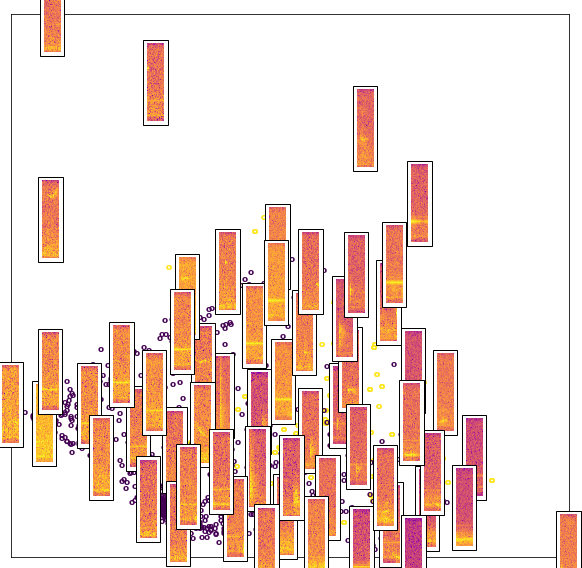

In [0]:
plot_embedding(X, pca_features[:,:2])

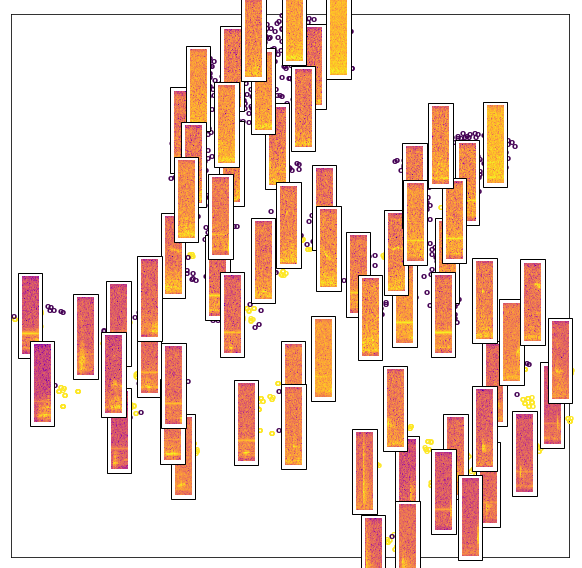

In [0]:
plot_embedding(X, tsne_features[:,:2])